In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


In [9]:
import sys
sys.path.append('../')

In [3]:
import nets.cornet.cornet_r as CR
import nets.cornet.cornet_s as CS
import nets.cornet.cornet_z as CZ


import nets.cornet.cornet_z_regression as CZR
import nets.cornet.cornet_s_regression as CSR

In [7]:
import torch
from skorch import NeuralNetClassifier
from skorch import NeuralNetRegressor
from skorch.helper import predefined_split
from skorch.dataset import Dataset

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split


import sklearn.metrics

In [13]:
sys.path.append('../external/perception/EXP/')
sys.path.append('../external/perception/EXP/ClevelandMcGill/')
import figure1

In [28]:
DATATYPE = figure1.Figure1.length

#
# DATA
#
train_target = 60000
val_target = 20000
test_target = 20000

# get global min and max
global_min = np.inf
global_max = -np.inf
for N in range(train_target+val_target+test_target):

    sparse, image, label, parameters = figure1.Figure1.length()

    global_min = min(label, global_min)
    global_max = max(label, global_max)
# end of global min max

# get the range and shuffle it.. just not the min and max since this will always be training data
labels_without_first_and_last = list(range(global_min+1, global_max))
label_count = len(labels_without_first_and_last)+2
np.random.shuffle(labels_without_first_and_last)

# assign target labels to train, val, and test data
train_target_labels = [global_min, global_max]
val_target_labels = []
test_target_labels = []

for i in range(int(label_count*.6) - 2):
    train_target_labels.append(labels_without_first_and_last.pop())
    
for i in range(int(label_count*.2)):
    val_target_labels.append(labels_without_first_and_last.pop())
    
for i in range(int(label_count*.2)):
    test_target_labels.append(labels_without_first_and_last.pop())

# make sure all 3 groups are unique
assert len(np.intersect1d(train_target_labels, val_target_labels)) == 0
assert len(np.intersect1d(train_target_labels, test_target_labels)) == 0
assert len(np.intersect1d(test_target_labels, val_target_labels)) == 0

#
# fill in the data
#
X_train = np.zeros((train_target, 100, 100), dtype=np.bool)
y_train = np.zeros((train_target), dtype=np.float32)
train_counter = 0

X_val = np.zeros((val_target, 100, 100), dtype=np.bool)
y_val = np.zeros((val_target), dtype=np.float32)
val_counter = 0

X_test = np.zeros((test_target, 100, 100), dtype=np.bool)
y_test = np.zeros((test_target), dtype=np.float32)
test_counter = 0

FLAGS = [True,False,False]
while train_counter < train_target:
    
    sparse, image, label, parameters = DATATYPE(FLAGS, preset=np.random.choice(train_target_labels))
    X_train[train_counter] = image
    y_train[train_counter] = label
    train_counter += 1
    
print('Training Parameters', parameters)
    
FLAGS = [True,False,False]
while val_counter < val_target:
    
    sparse, image, label, parameters = DATATYPE(FLAGS, preset=np.random.choice(val_target_labels))
    X_val[val_counter] = image
    y_val[val_counter] = label
    val_counter += 1
    
FLAGS = [False,True,False]
while test_counter < test_target:
    
    sparse, image, label, parameters = DATATYPE(FLAGS, preset=np.random.choice(test_target_labels))
    X_test[test_counter] = image
    y_test[test_counter] = label
    test_counter += 1
    
print('Testing Parameters', parameters)


Training Parameters 2400
Testing Parameters 3600


In [29]:
#
#
# NORMALIZE DATA IN-PLACE (BUT SEPERATELY)
#
#
X_train = X_train.astype(np.float32)
X_val = X_val.astype(np.float32)
X_test = X_test.astype(np.float32)

X_min = X_train.min()
X_max = X_train.max()
y_min = y_train.min()
y_max = y_train.max()

# scale in place
X_train -= X_min
X_train /= (X_max - X_min)
y_train -= y_min
y_train /= (y_max - y_min)

X_val -= X_min
X_val /= (X_max - X_min)
y_val -= y_min
y_val /= (y_max - y_min)

X_test -= X_min
X_test /= (X_max - X_min)
y_test -= y_min
y_test /= (y_max - y_min)

# normalize to -.5 .. .5
X_train -= .5
X_val -= .5
X_test -= .5


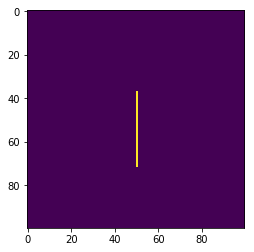

In [30]:
imshow(X_train[2314])

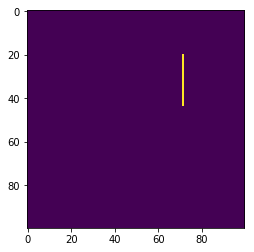

In [31]:
imshow(X_test[120])

In [21]:
X_train.shape, X_val.shape, X_test.shape

((60000, 100, 100), (20000, 100, 100), (20000, 100, 100))

In [22]:
#
# CREATE 3 CHANNELS
#
X_train_ = X_train.reshape(X_train.shape[0],1,X_train.shape[-2],X_train.shape[-1])
X_train_rgb = np.zeros((X_train.shape[0], 3, X_train.shape[-2], X_train.shape[-1]), dtype=X_train.dtype)
X_train_rgb[:,:,:,:] = X_train_

X_val_ = X_val.reshape(X_val.shape[0],1,X_val.shape[-2],X_val.shape[-1])
X_val_rgb = np.zeros((X_val.shape[0], 3, X_val.shape[-2], X_val.shape[-1]), dtype=X_val.dtype)
X_val_rgb[:,:,:,:] = X_val_

X_test_ = X_test.reshape(X_test.shape[0],1,X_test.shape[-2],X_test.shape[-1])
X_test_rgb = np.zeros((X_test.shape[0], 3, X_test.shape[-2], X_test.shape[-1]), dtype=X_test.dtype)
X_test_rgb[:,:,:,:] = X_test_

In [25]:
# reshape regression target
y_train_ = y_train.reshape(-1, 1)
y_val_ = y_val.reshape(-1, 1)
y_test_ = y_test.reshape(-1, 1)

In [27]:
#
# WE ARE TRYING RIGHT NOW TO HAVE X_VAR IN THE TRAINING/VAL. BUT Y_VAR AND WIDTH FOR TESTING
#
Z = NeuralNetRegressor(
    CZR.CORnet_Z_Regression,
    max_epochs=30,
    lr=1e-3,
    batch_size=32,
    train_split=predefined_split(Dataset(X_val_rgb, y_val_)),
    device='cuda'
)
Z.fit(X_train_rgb, y_train_);
y_pred = Z.predict(X_test_rgb)
# print('Test acc.:', np.mean(y_pred == y_test_))
print('Test MAE:', sklearn.metrics.mean_absolute_error(y_pred, y_test_))
MLAE = np.log2(sklearn.metrics.mean_absolute_error(y_pred*100, y_test_*100)+.125)
print('Test MLAE:', MLAE)

  epoch    train_loss    valid_loss      dur
-------  ------------  ------------  -------
      1        0.0774        0.0498  23.8971
      2        0.0284        0.0070  22.2418
      3        0.0072        0.0054  22.6275
      4        0.0046        0.0052  22.8305
      5        0.0037        0.0044  22.8372
      6        0.0031        0.0036  22.9005
      7        0.0025        0.0030  22.8225
      8        0.0021        0.0024  22.6814
      9        0.0017        0.0019  22.7144
     10        0.0014        0.0016  23.2620
     11        0.0012        0.0012  23.5810
     12        0.0010        0.0010  23.4473
     13        0.0008        0.0008  23.4282
     14        0.0007        0.0006  23.4530
     15        0.0006        0.0005  23.4375
     16        0.0005        0.0004  23.5052
     17        0.0004        0.0004  23.4422
     18        0.0004        0.0003  23.5545
     19        0.0003        0.0003  23.4520
     20        0.0003        0.0002  23.6196
     21   

In [32]:
#
# WE ARE TRYING RIGHT NOW TO HAVE X_VAR IN THE TRAINING/VAL. AND ONLY Y_VAR FOR TESTING
#
Z = NeuralNetRegressor(
    CZR.CORnet_Z_Regression,
    max_epochs=30,
    lr=1e-3,
    batch_size=32,
    train_split=predefined_split(Dataset(X_val_rgb, y_val_)),
    device='cuda'
)
Z.fit(X_train_rgb, y_train_);
y_pred = Z.predict(X_test_rgb)
# print('Test acc.:', np.mean(y_pred == y_test_))
print('Test MAE:', sklearn.metrics.mean_absolute_error(y_pred, y_test_))
MLAE = np.log2(sklearn.metrics.mean_absolute_error(y_pred*100, y_test_*100)+.125)
print('Test MLAE:', MLAE)

  epoch    train_loss    valid_loss      dur
-------  ------------  ------------  -------
      1        0.0782        0.0524  22.7491
      2        0.0296        0.0071  22.6224
      3        0.0071        0.0055  23.9295
      4        0.0045        0.0051  23.9396
      5        0.0035        0.0042  22.9054
      6        0.0028        0.0034  24.2044
      7        0.0022        0.0026  22.8426
      8        0.0018        0.0021  24.2846
      9        0.0014        0.0016  23.5142
     10        0.0011        0.0012  23.6539
     11        0.0009        0.0010  24.2584
     12        0.0007        0.0007  22.9008
     13        0.0006        0.0006  24.2865
     14        0.0005        0.0005  22.8782
Test MAE: 0.30420116
Test MLAE: 4.932869834235494


In [33]:
S = NeuralNetRegressor(
    CSR.CORnet_S_Regression,
    max_epochs=30,
    lr=1e-3,
    batch_size=32,
    train_split=predefined_split(Dataset(X_val_rgb, y_val_)),
    device='cuda'
)
S.fit(X_train_rgb, y_train_);
y_pred = S.predict(X_test_rgb)
# print('Test acc.:', np.mean(y_pred == y_test_))
print('Test MAE:', sklearn.metrics.mean_absolute_error(y_pred, y_test_))
MLAE = np.log2(sklearn.metrics.mean_absolute_error(y_pred*100, y_test_*100)+.125)
print('Test MLAE:', MLAE)

  epoch    train_loss    valid_loss       dur
-------  ------------  ------------  --------
      1        0.0024        0.0039  496.5834
      2        0.0007        0.0033  496.8037
      3        0.0005        0.0034  496.6461
      4        0.0004        0.0032  496.4255
      5        0.0004        0.0031  496.2965
      6        0.0003        0.0030  495.9736
      7        0.0003        0.0029  496.2188
Test MAE: 1.2610775
Test MLAE: 6.979942442765149


In [574]:
S = NeuralNetRegressor(
    CSR.CORnet_S_Regression,
    max_epochs=30,
    lr=1e-3,
    batch_size=32,
    train_split=predefined_split(Dataset(X_val_rgb, y_val_)),
    device='cuda'
)
S.fit(X_train_rgb, y_train_);
y_pred = S.predict(X_test_rgb)
# print('Test acc.:', np.mean(y_pred == y_test_))
print('Test MAE:', sklearn.metrics.mean_absolute_error(y_pred, y_test_))
MLAE = np.log2(sklearn.metrics.mean_absolute_error(y_pred*100, y_test_*100)+.125)
print('Test MLAE:', MLAE)

  epoch    train_loss    valid_loss       dur
-------  ------------  ------------  --------
      1        0.0011       15.9672  495.6455
      2        0.0002       13.6742  497.0290
      3        0.0001       13.6325  496.8716
      4        0.0001       13.2963  496.8030
Test MAE: 2.687762
Test MLAE: 8.070932461507919


In [7]:
R = NeuralNetClassifier(
    CR.CORnet_R,
    max_epochs=30,
    lr=1e-3,
    batch_size=128,
    criterion=torch.nn.CrossEntropyLoss,
    device='cuda'
)

In [8]:
R.fit(X_train_rgb, y_train);
y_pred = R.predict(X_test_rgb)
print('Test acc.:', np.mean(y_pred == y_test))

RuntimeError: The size of tensor a (4) must match the size of tensor b (28) at non-singleton dimension 3

In [6]:
S = NeuralNetClassifier(
    CS.CORnet_S,
    max_epochs=30,
    lr=1e-3,
    batch_size=128,
    criterion=torch.nn.CrossEntropyLoss,
    device='cuda'
)


In [7]:
S.fit(X_train_rgb, y_train);
y_pred = S.predict(X_test_rgb)
print('Test acc.:', np.mean(y_pred == y_test))

  epoch    train_loss    valid_acc    valid_loss       dur
-------  ------------  -----------  ------------  --------
      1        1.7792       0.9251        0.3259  171.9588
      2        0.2155       0.9527        0.1741  171.9808
      3        0.1182       0.9613        0.1397  171.9605
Test acc.: 0.9594857142857143
